In [ ]:
from google.colab import files


uploaded = files.upload()

Saving student_habits_performance.csv to student_habits_performance.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

In [ ]:
# Load the data
df = pd.read_csv('student_habits_performance.csv')

In [ ]:
# Initial EDA
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (1000, 16)

First 5 rows:
  student_id  age  gender  study_hours_per_day  social_media_hours  \
0      S1000   23  Female                  0.0                 1.2   
1      S1001   20  Female                  6.9                 2.8   
2      S1002   21    Male                  1.4                 3.1   
3      S1003   23  Female                  1.0                 3.9   
4      S1004   19  Female                  5.0                 4.4   

   netflix_hours part_time_job  attendance_percentage  sleep_hours  \
0            1.1            No                   85.0          8.0   
1            2.3            No                   97.3          4.6   
2            1.3            No                   94.8          8.0   
3            1.0            No                   71.0          9.2   
4            0.5            No                   90.9          4.9   

  diet_quality  exercise_frequency parental_education_level internet_quality  \
0         Fair                   6   

In [ ]:
print("\nData types and missing values:")
print(df.info())


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality 

In [ ]:
print("\nDescriptive statistics:")
print(df.describe())


Descriptive statistics:
             age  study_hours_per_day  social_media_hours  netflix_hours  \
count  1000.0000           1000.00000         1000.000000    1000.000000   
mean     20.4980              3.55010            2.505500       1.819700   
std       2.3081              1.46889            1.172422       1.075118   
min      17.0000              0.00000            0.000000       0.000000   
25%      18.7500              2.60000            1.700000       1.000000   
50%      20.0000              3.50000            2.500000       1.800000   
75%      23.0000              4.50000            3.300000       2.525000   
max      24.0000              8.30000            7.200000       5.400000   

       attendance_percentage  sleep_hours  exercise_frequency  \
count            1000.000000  1000.000000         1000.000000   
mean               84.131700     6.470100            3.042000   
std                 9.399246     1.226377            2.025423   
min                56.000000  

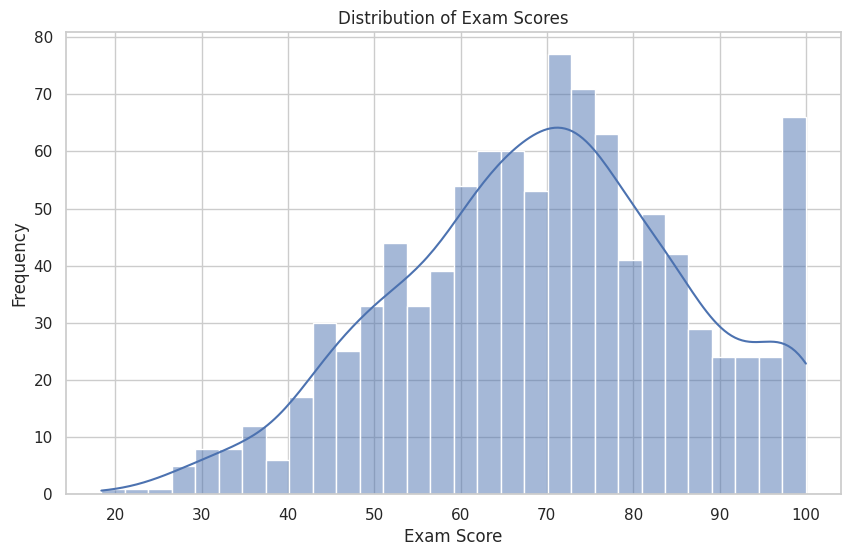

In [ ]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['exam_score'], bins=30, kde=True)
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.show()

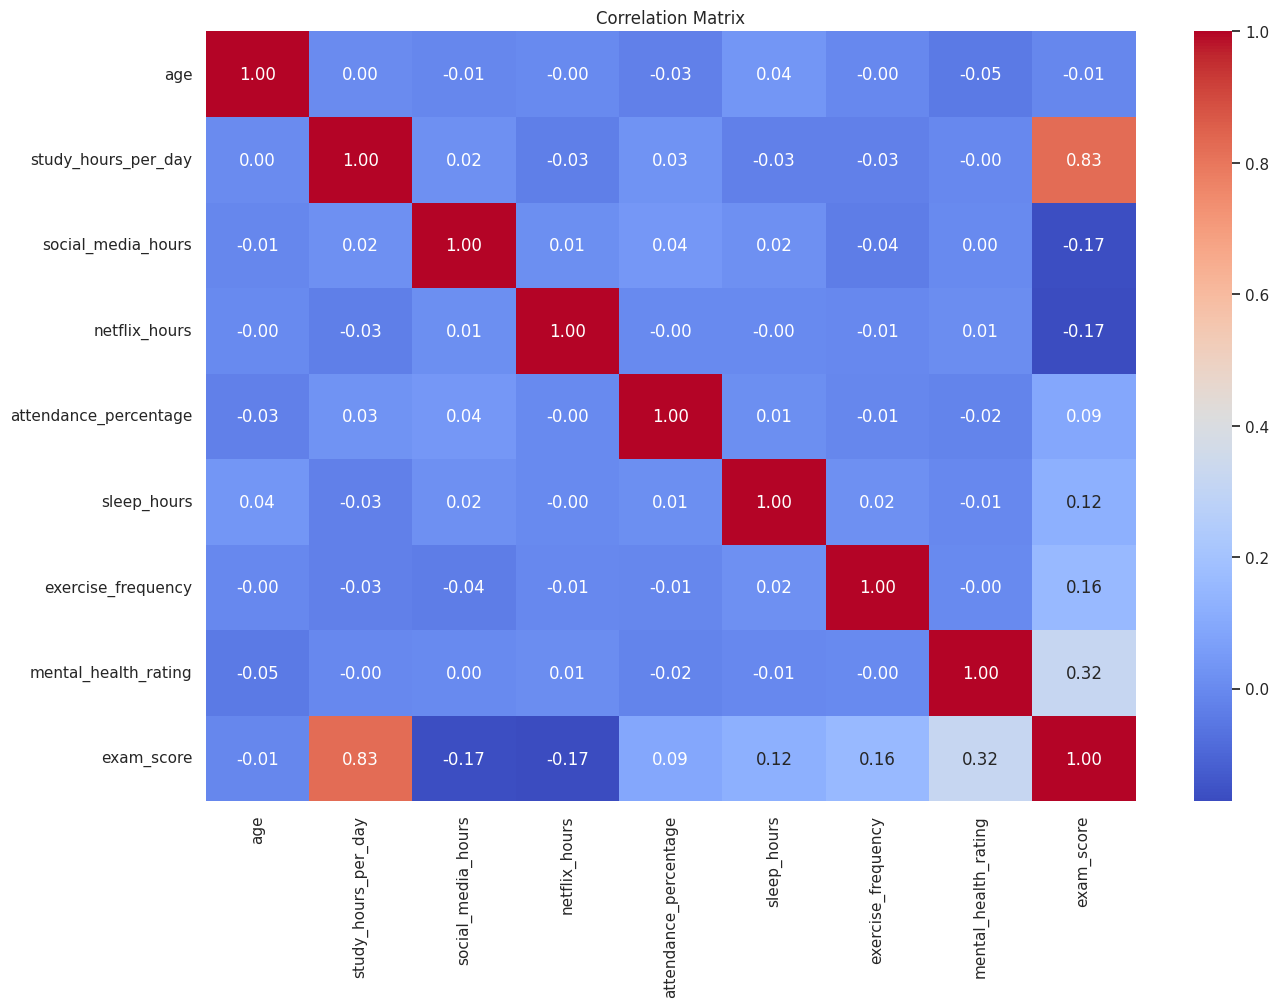

In [ ]:
# Correlation analysis
plt.figure(figsize=(15, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Top correlations with exam_score
exam_corr = corr_matrix['exam_score'].sort_values(ascending=False)
print("\nTop correlations with exam_score:")
print(exam_corr)


Top correlations with exam_score:
exam_score               1.000000
study_hours_per_day      0.825419
mental_health_rating     0.321523
exercise_frequency       0.160107
sleep_hours              0.121683
attendance_percentage    0.089836
age                     -0.008907
social_media_hours      -0.166733
netflix_hours           -0.171779
Name: exam_score, dtype: float64


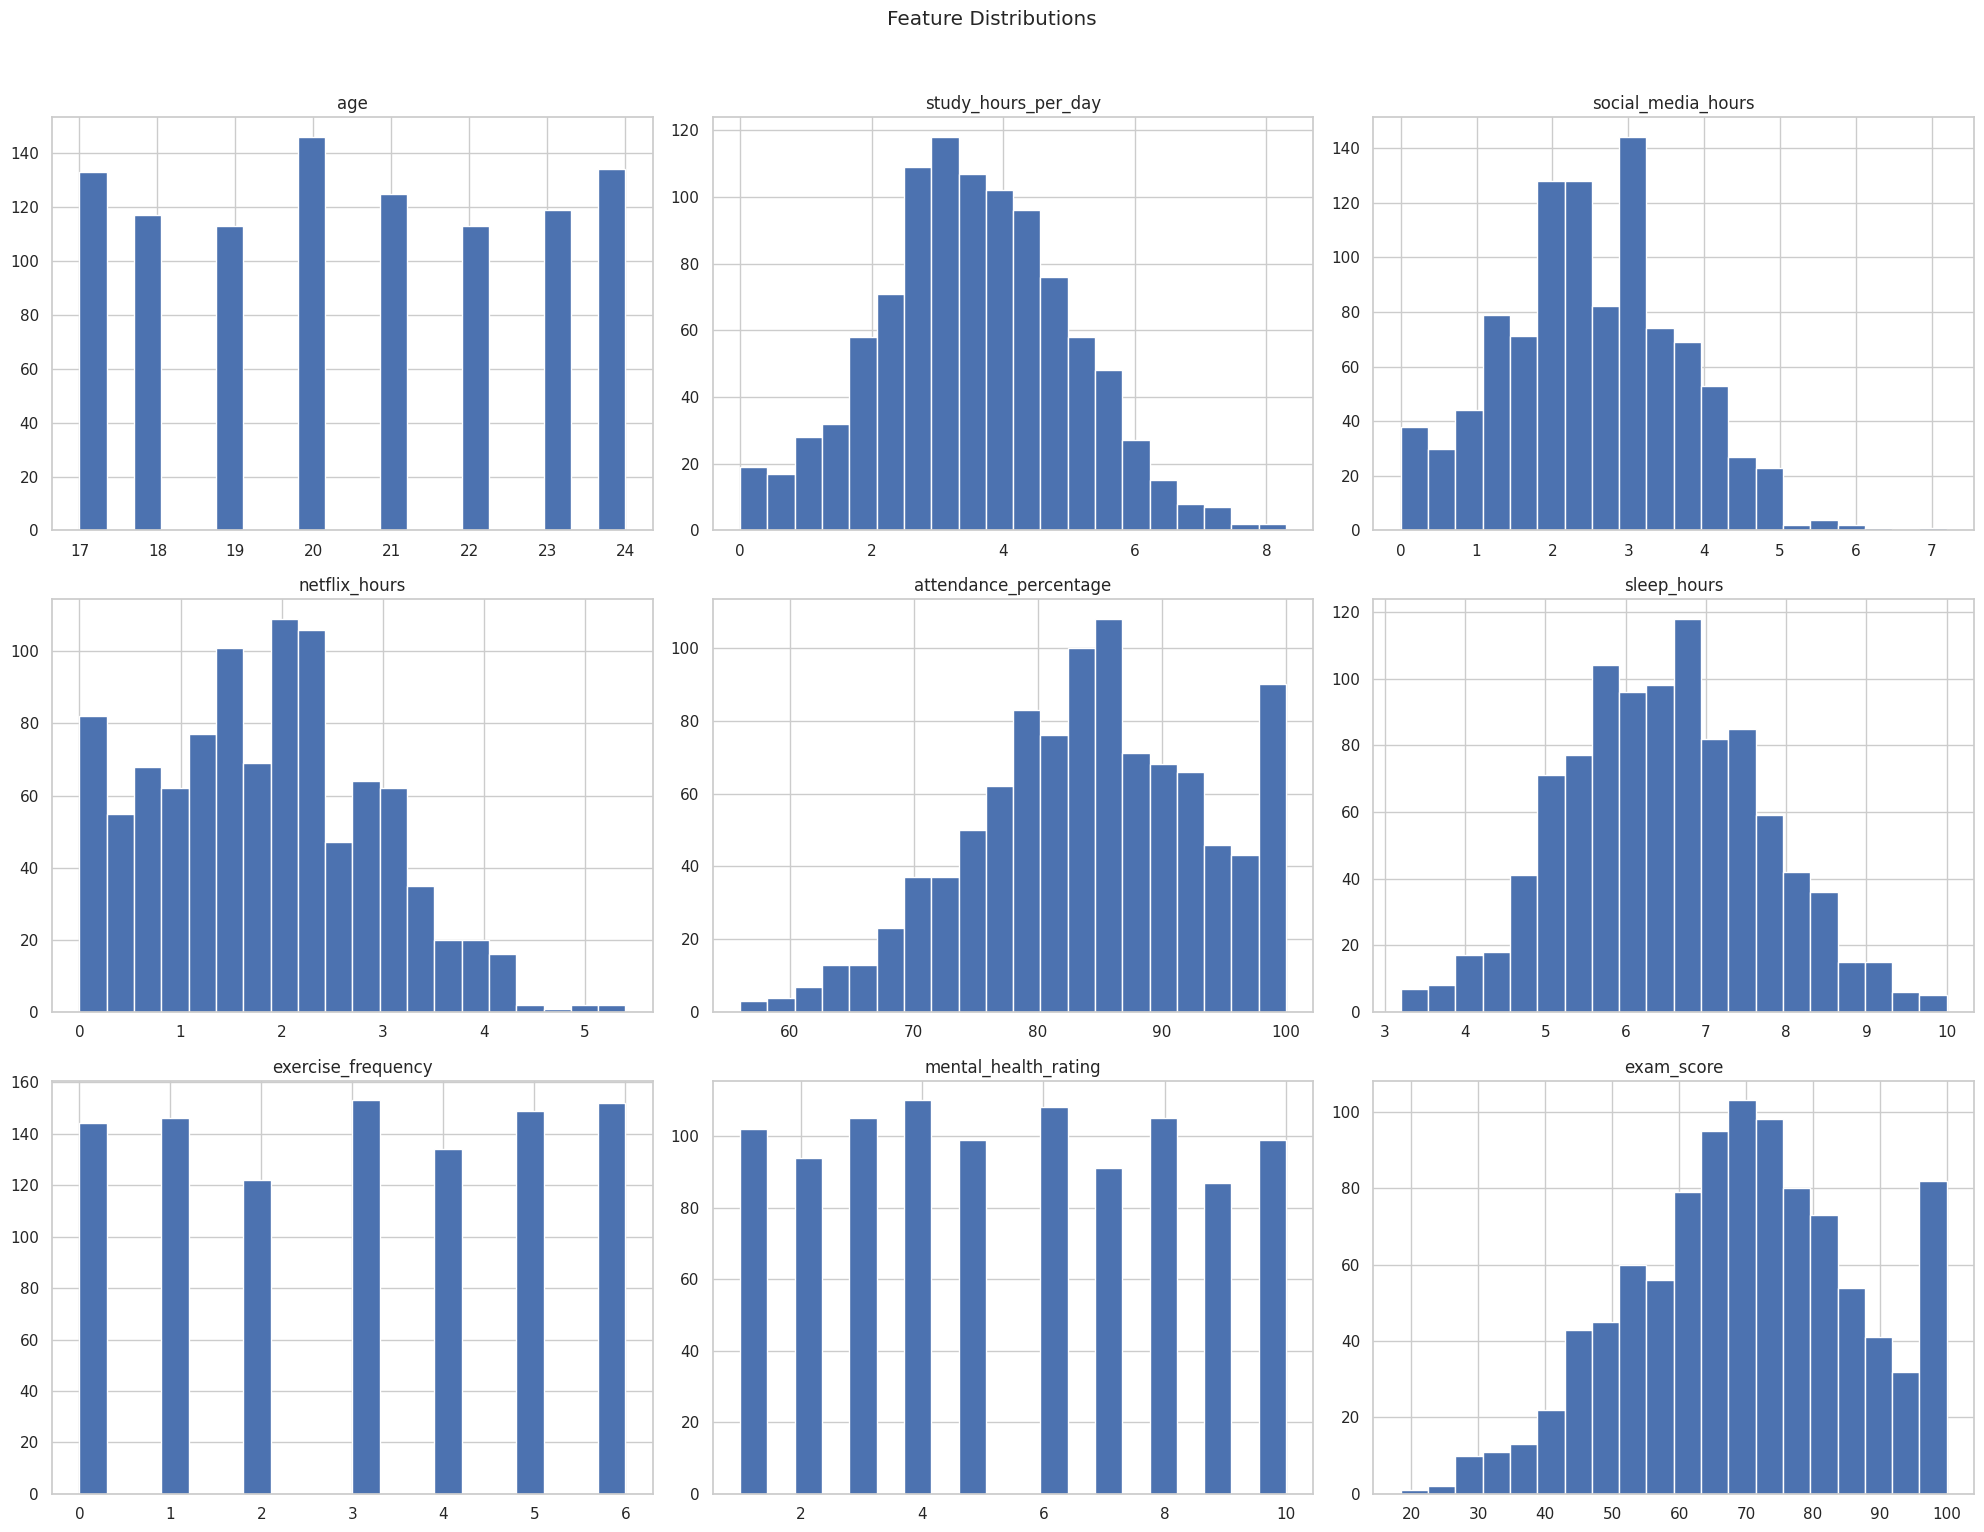

In [ ]:
# Feature distributions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=20, figsize=(20, 15))
plt.suptitle('Feature Distributions', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Feature engineering
# Create a total leisure time feature
df['total_leisure_hours'] = df['social_media_hours'] + df['netflix_hours']

# Create a productivity ratio (study hours vs leisure)
df['productivity_ratio'] = df['study_hours_per_day'] / (df['total_leisure_hours'] + 0.01)  # Add small value to avoid division by zero

# Convert categorical variables
df = pd.get_dummies(df, columns=['gender', 'part_time_job', 'diet_quality', 'parental_education_level',
                               'internet_quality', 'extracurricular_participation'], drop_first=True)

In [ ]:
# Feature engineering
# Create a total leisure time feature
df['total_leisure_hours'] = df['social_media_hours'] + df['netflix_hours']

# Create a productivity ratio (study hours vs leisure)
df['productivity_ratio'] = df['study_hours_per_day'] / (df['total_leisure_hours'] + 0.01)  # Add small value to avoid division by zero

# Convert categorical variables
# Check for correct column names
print(df.columns)

# Fix any misspellings or use the actual column names
df = pd.get_dummies(df, columns=['gender', 'part_time_job', 'diet_quality', 'parental_education_level',
                               'internet_quality', 'extracurricular_participation'], drop_first=True)

In [ ]:
# Prepare data for modeling
X = df.drop(['student_id', 'exam_score'], axis=1)
y = df['exam_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

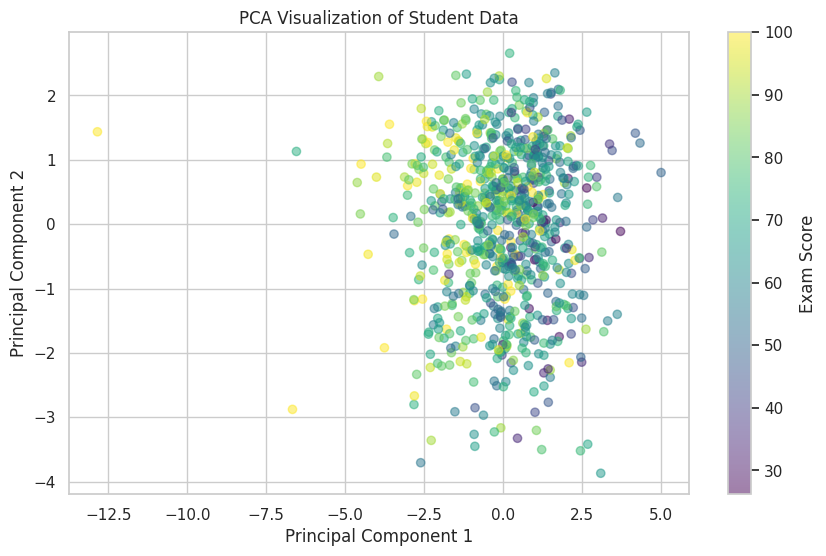

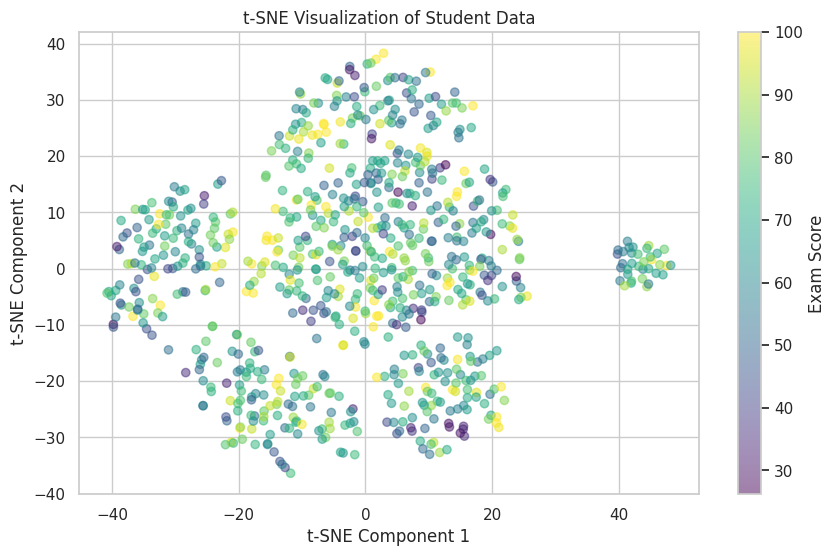

In [ ]:
# Dimensionality reduction visualization
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar(label='Exam Score')
plt.title('PCA Visualization of Student Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar(label='Exam Score')
plt.title('t-SNE Visualization of Student Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Feature selection
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X_train_scaled, y_train)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("\nTop 10 selected features:")
print(selected_features)

# Model comparison
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42, max_iter=1000)
}

results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    results[name] = cv_scores.mean()
    print(f"{name}: Mean R2 = {cv_scores.mean():.3f}")



Top 10 selected features:
Index(['study_hours_per_day', 'social_media_hours', 'netflix_hours',
       'attendance_percentage', 'sleep_hours', 'exercise_frequency',
       'mental_health_rating', 'total_leisure_hours', 'productivity_ratio',
       'diet_quality_Poor'],
      dtype='object')
Linear Regression: Mean R2 = 0.894
Random Forest: Mean R2 = 0.856
XGBoost: Mean R2 = 0.848
SVR: Mean R2 = 0.619
MLP: Mean R2 = 0.847


In [ ]:
# Hyperparameter tuning for top models
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2')
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

# XGBoost
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=5, scoring='r2')
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_

In [ ]:
# Evaluate best models on test set
final_models = {
    'Random Forest (tuned)': best_rf,
    'XGBoost (tuned)': best_xgb
}

for name, model in final_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\n{name} Test Performance:")
    print(f"R2 Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")


Random Forest (tuned) Test Performance:
R2 Score: 0.854
RMSE: 6.121

XGBoost (tuned) Test Performance:
R2 Score: 0.866
RMSE: 5.859


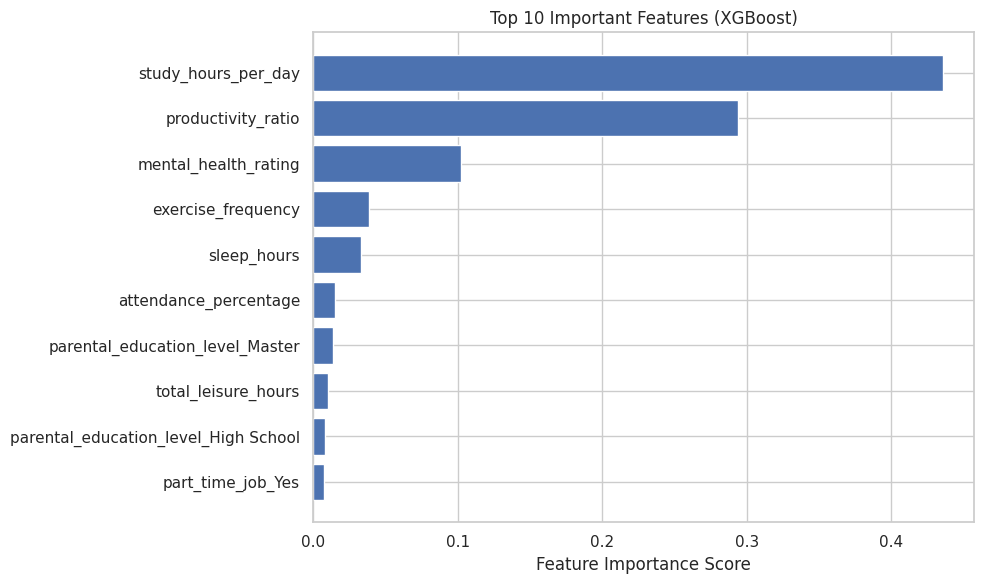

In [ ]:
# Feature importance for best model
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.title('Top 10 Important Features (XGBoost)')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

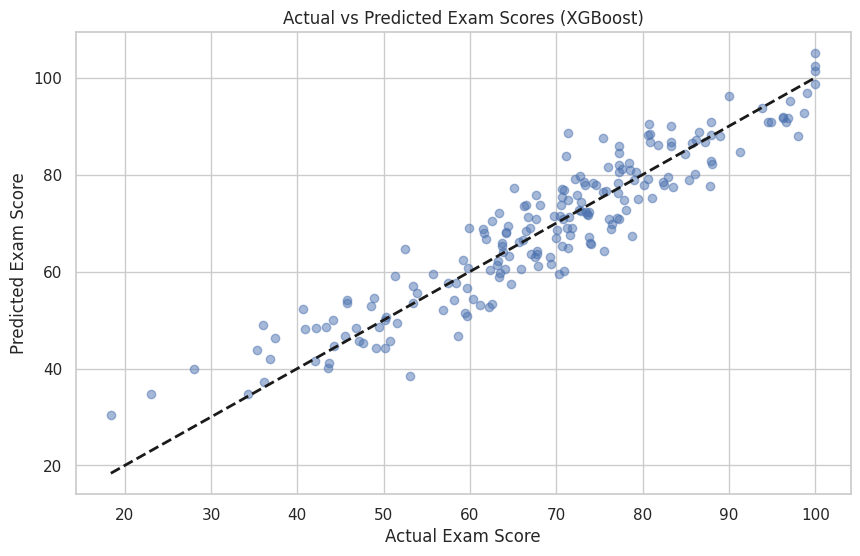

In [ ]:
# Actual vs Predicted plot for best model
y_pred = best_xgb.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Actual vs Predicted Exam Scores (XGBoost)')
plt.show()